# Vehicle tracking

## Data import

In [2]:
import numpy as np
import numpy.matlib as ml
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.mplot3d import Axes3D
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
import time
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

In [3]:
non_vehicles_path = ["data\\non-vehicles\\non-vehicles\\GTI",
                     "data\\non-vehicles\\non-vehicles\\Extras"]

vehicle_path_split = ["data\\vehicles\\vehicles\\GTI_Far",
                      "data\\vehicles\\vehicles\\GTI_Left",
                      "data\\vehicles\\vehicles\\GTI_MiddleClose",
                      "data\\vehicles\\vehicles\\GTI_Right"]

vehicle_path_no_split = ["data\\vehicles\\vehicles\\KITTI_extracted"]

In [4]:
def get_complete_path(paths):
    out = []
    for path in paths:
        files = os.listdir(path)
        combined = [os.path.join(path, file) for file in files if file[-3:] == "png"]
        out.extend(combined)
    return out

In [5]:
def split_sequence(l, frac):
    n = len(l)
    start_seq = np.random.randint(0, n)
    offset = int(n*frac)
    end_seq = start_seq + offset
    if end_seq > n:
        end_seq = end_seq - n
        out1 = l[start_seq:] + l[:end_seq]
        out2 = l[end_seq:start_seq]
    else:
        out1 = l[start_seq:end_seq]
        out2 = l[:start_seq] + l[end_seq:]
    return out1,out2    

In [6]:
l = [1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4]
out1, out2 = split_sequence(l, 0.3)
print(out1)
print(out2)
print(len(out1)/len(out2))

[3, 3, 3, 4, 4]
[1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 4, 4]
0.38461538461538464


In [7]:
def import_img(paths, label, size = (64,64,3)):
    n = len(paths)
    X = np.zeros(shape = (n, size[0], size[1], size[2]))
    y = np.ones(n)*label
    for i, path in enumerate(paths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X[i] = img
    return X,y

In [8]:
split = 0.2

## Handle time sequence data
veh_test_s, veh_train_s = split_sequence(get_complete_path(vehicle_path_split), split)

## Randomly split the rest
veh_train_ns, veh_test_ns = train_test_split(get_complete_path(vehicle_path_no_split), test_size=split)
no_veh_train, no_veh_test = train_test_split(get_complete_path(non_vehicles_path), test_size=split)

## Import images
X1, y1 = import_img(veh_train_ns + veh_train_s, 1)
X2, y2 = import_img(no_veh_train, 0)
X_train, y_train = np.vstack((X1, X2)),  np.hstack((y1, y2))
X_train, y_train = shuffle(X_train, y_train)
X1, y1 = import_img(veh_test_ns + veh_test_s, 1)
X2, y2 = import_img(no_veh_test, 0)
X_test,  y_test  = np.vstack((X1, X2)),  np.hstack((y1, y2))
X_test, y_test = shuffle(X_test, y_test)

## Data exploration

In [8]:
## Total count
nVeh = len(veh_test_s) + len(veh_train_ns) + len(veh_train_ns) + len(veh_test_ns)
nNoVeh = len(no_veh_train) + len(no_veh_test)
print("Total number of vehicles = ", nVeh)
print("Total number of non-vehciles = ", nNoVeh)

## Set count
nTrain = X_train.shape[0]
nTest = X_test.shape[0]
print("Total number of train features = ", nTrain)
print("Total number of test features = ", nTest)
print("Test to train ratio = ", nTest/(nTrain+nTest))

## Set spread
nVehTrain = len([label for label in y_train if label == 1])
nNoVehTrain = len([label for label in y_train if label == 0])
nVehTest = len([label for label in y_test if label == 1])
nNoVehTest = len([label for label in y_test if label == 0])
print("Ratio of vehicles to non-vehicles in the train set = ", nVehTrain/nNoVehTrain)
print("Ratio of vehicles to non-vehicles in the train set = ", nVehTest/nNoVehTest)

Total number of vehicles =  11303
Total number of non-vehciles =  8968
Total number of train features =  14207
Total number of test features =  3553
Test to train ratio =  0.2000563063063063
Ratio of vehicles to non-vehicles in the train set =  0.9803456927794815
Ratio of vehicles to non-vehicles in the train set =  0.9804905239687849


In [9]:
def plot_img(X, label, ax, cmap):
    ax.imshow(X.astype(np.uint8), cmap)
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])

In [10]:
def plot_sign_array(X_data, y_data, n_height = 5, n_width = 4, cmap = None):
    """Creates a grid of subplots of size [n_width, n_height] in which images are plotted using the provided
    data. The images to be plotted are drawn randomly from the provided set if indexes is set to None. The
    color map can be adapted in case of grayscale images."""
    # Grid of subplots
    f, axarr = plt.subplots(n_height, n_width, figsize = (n_width*3,n_height*2))
    i = 0    
    
    # Iterate over each subplot
    for row in axarr:
        for ax in row:            
            # Extract index of image to be plotted
            index = int(np.random.randint(0, len(y_data)-1))
            
            # Process data and plot image
            names = ["No vehicle", "Vehicle"]
            label = names[int(y_data[index])]
            plot_img(X_data[index], label, ax, cmap)
    plt.show()

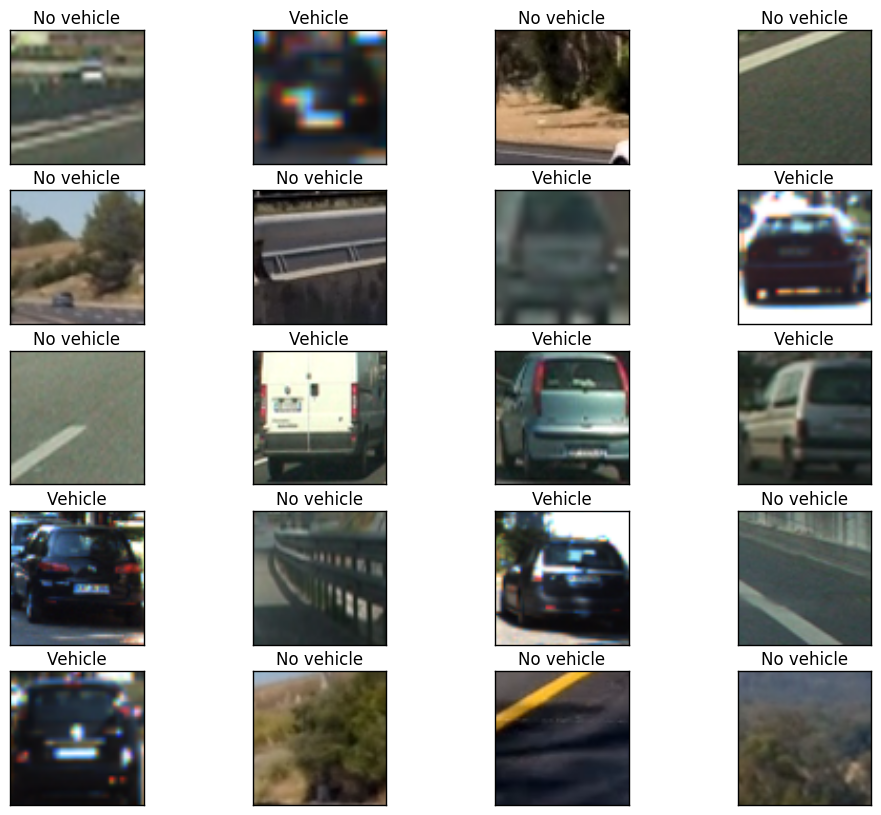

In [11]:
plot_sign_array(X_train, y_train)

## Features

### Spatial binning

In [12]:
def change_color_space(img, color_space):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img) 
    return feature_image

In [13]:
# Binned color features  
def bin_spatial(img, color_space='RGB', size=(32, 32), ravel = True):
    # Convert image to new color space (if specified)
    feature_image = change_color_space(img, color_space)           
    feature_image = cv2.resize(feature_image, size)
    
    # Compute feature vector
    if ravel == True:
        feature_image = feature_image.ravel() 
    return feature_image

In [14]:
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)], ax = None):
    """Plot pixels in 3D."""
    
    if ax == None:
        # Create figure and 3D axes
        fig = plt.figure(figsize=(8, 8))
        ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

In [15]:
def print_cs(X, y, cs = "RGB", n = 16):
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    for i in range(n):
        index = np.random.randint(0,X.shape[0])
        img = X[index]
        img_bin = bin_spatial(img.astype(np.uint8), cs, size = (16,16), ravel = False)
        if y[index] == 1:
            color = (1,0,0)
        else:
            color = (0,0,0)
        colors = ml.repmat(color,img_bin.shape[0]*img_bin.shape[1], 1)
        plot3d(img_bin, colors, axis_labels = list(cs), ax = ax)
    plt.show()

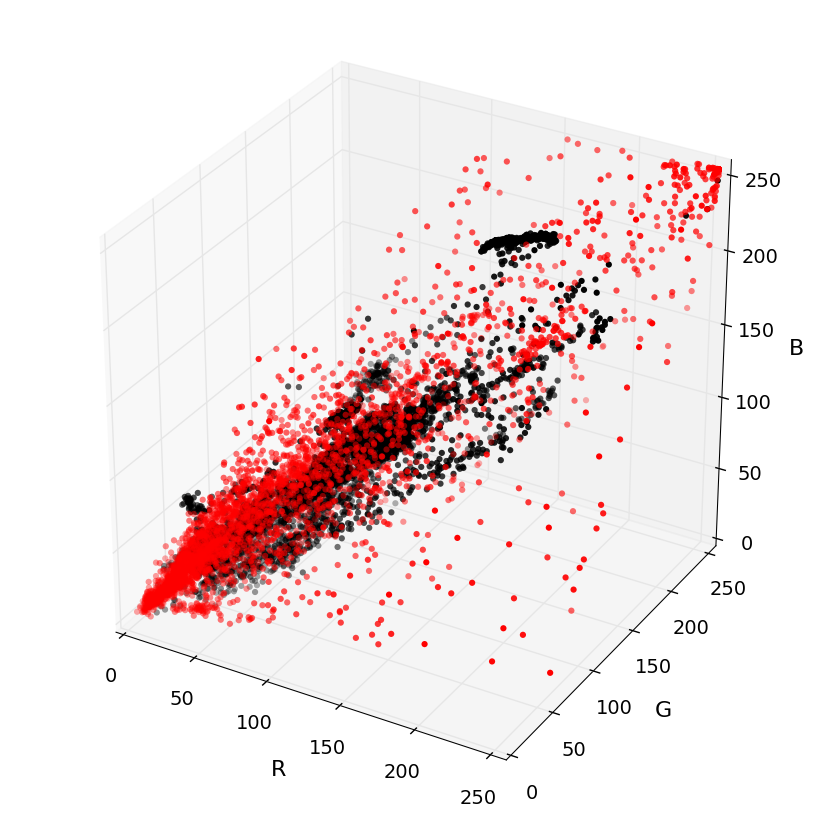

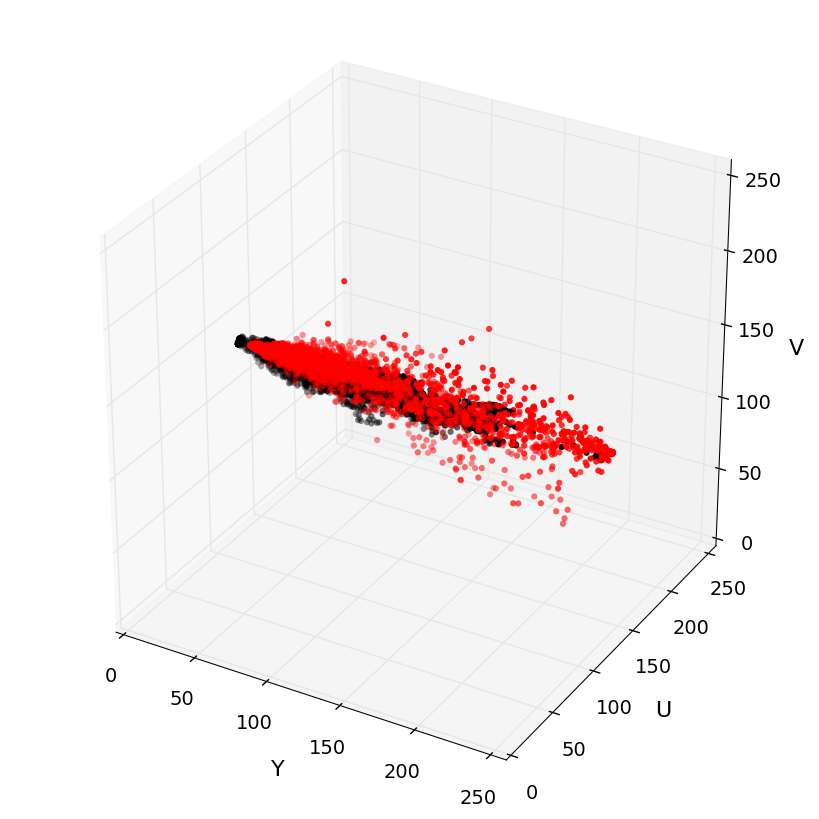

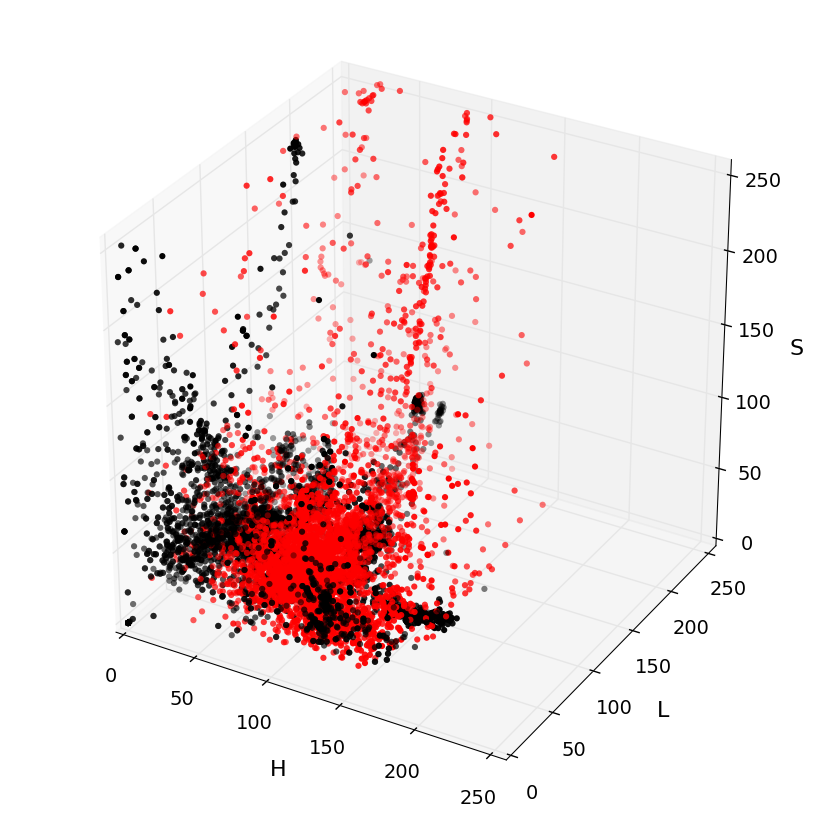

In [16]:
print_cs(X_train, y_train, n = 32)
print_cs(X_train, y_train, cs = "YUV", n = 32)
print_cs(X_train, y_train, cs = "HLS", n = 32)

## Color histogram

In [17]:
# Color histogram features  
def color_hist(img, color_space='RGB', nbins=32, bins_range=(0, 256)):
    # Convert image to new color space (if specified)
    img = change_color_space(img, color_space)           
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features

In [18]:
def color_hist_plot(features, titles = list("RGB"), nbins=32, bins_range=(0, 256)):
    offset = (bins_range[1] - bins_range[0])/nbins/2
    bin_centers = np.linspace(offset + bins_range[0],bins_range[1]-offset,nbins)
    n_rep = features.shape[0]/nbins
    # Plot a figure with all three bar charts
    f, axarr = plt.subplots(1, int(n_rep), figsize = (n_rep*3,3))
    for i, ax in enumerate(axarr):
        hist = features[i:i+nbins]
        ax.bar(bin_centers, hist)
        ax.set_xlim(bins_range[0], bins_range[1])
        ax.set_title('Histogram ' + titles[i])
    plt.show()

In [1]:
features = color_hist(X_train[4])
color_hist_plot(features)
plt.figure()
plt.imshow(X_train[5].astype(np.uint8))
plt.show()

NameError: name 'color_hist' is not defined

## Hog features

In [20]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):

    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

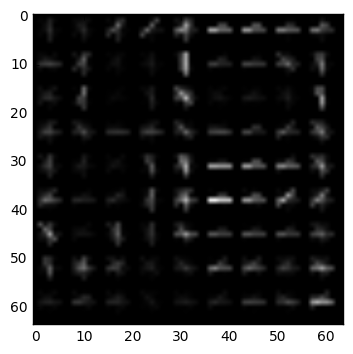

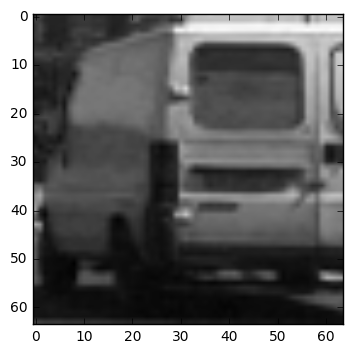

In [75]:
features, hog_image = get_hog_features(X_train[100,:,:,1], 10, 7, 5, vis = True)
plt.imshow(hog_image, cmap = 'gray')
plt.show()
plt.figure()
plt.imshow(X_train[100,:,:,1], cmap = 'gray')
plt.show()

## Combined feature extraction

In [22]:
def scale(X):
    X_scaler = StandardScaler().fit(X)
    return X_scaler.transform(X), X_scaler

In [23]:
def extract_features(X, settings):
    
    # Create a list to append feature vectors to
    features = []
    n = X.shape[0]
    
    # Iterate through the list of images
    for i in range(n):
        # Store features for current input
        X_features = []
        
        # Read in each one by one
        img = X[i]
        
        # Apply spacial binning
        if settings["bin"]["flag"] == True:
            spatial_features = bin_spatial(img.astype(np.uint8), 
                                           size=settings["bin"]["size"], 
                                           color_space=settings["bin"]["cs"])
            X_features.append(spatial_features)
            
        # Apply histogram binning
        if settings["hist"]["flag"] == True:
            hist_features = color_hist(img.astype(np.uint8), 
                                       nbins=settings["hist"]["nbins"], 
                                       color_space=settings["hist"]["cs"])
            X_features.append(hist_features)
        
        # Apply hog features
        if settings["hog"]["flag"] == True:
            # Get all channels
            img = change_color_space(img.astype(np.uint8), settings["hog"]["cs"])
            if settings["hog"]["channel"] == 'ALL':
                hog_features = []
                for channel in range(img.shape[2]):
                    hog_features.append(get_hog_features(img[:,:,channel].astype(np.uint8), 
                                        settings["hog"]["orient"],
                                        settings["hog"]["pix_per_cell"], 
                                        settings["hog"]["pix_per_block"], 
                                        vis=False, feature_vec=True))
                    
                hog_features = np.ravel(hog_features)      
            # Get a defined channel
            else:
                hog_features = get_hog_features(img[:,:,settings["hog"]["channel"]].astype(np.uint8), 
                                                settings["hog"]["orient"], 
                                                settings["hog"]["pix_per_cell"], 
                                                settings["hog"]["pix_per_block"], 
                                                vis=False, feature_vec=True)
                
            # Append the new feature vector to the features list
            X_features.append(hog_features)
        features.append(np.concatenate(X_features))
        
    # Return list of feature vectors
    return features

In [91]:
# Spacial binning settings
bin_settings = {}
bin_settings["flag"] = True
bin_settings["size"] = (32,32)
bin_settings["cs"] = "YCrCb"
# Histogram binning settings
hist_settings = {}
hist_settings["flag"] = True
hist_settings["nbins"] = 32
hist_settings["cs"] = "YCrCb"
# Hog settings
hog_settings = {}
hog_settings["flag"] = True
hog_settings["orient"] = 9
hog_settings["pix_per_cell"] = 8
hog_settings["pix_per_block"] = 2
hog_settings["channel"] = 'ALL'
hog_settings["cs"] = "YCrCb"
# Group
settings = {}
settings["bin"] = bin_settings
settings["hist"] = hist_settings
settings["hog"] = hog_settings
# Test
feature_train = extract_features(X_train, settings)
print(len(feature_train))
print(X_train.shape[0])
print(feature_train[0].shape)

14207
14207
(8460,)


# SVC training

In [92]:
def print_settings(settings):
    print("== Feature settings ==")
    if settings["bin"]["flag"] == True:
        print("- Spacial binning")
        print("    - Size = ", settings["bin"]["size"])
        print("    - Color space = ", settings["bin"]["cs"])
    if settings["hist"]["flag"] == True:
        print("- Histogram binning")
        print("    - Number of bins = ", settings["hist"]["nbins"])
        print("    - Color space = ", settings["hist"]["cs"])
    if settings["hog"]["flag"] == True:
        print("- HOG")
        print("    - Orientation = ", settings["hog"]["orient"])
        print("    - Pix per cell = ", settings["hog"]["pix_per_cell"])
        print("    - Pix per block = ", settings["hog"]["pix_per_block"])
        print("    - Channel = ", settings["hog"]["channel"])
        print("    - Color space = ", settings["hog"]["cs"])
        
print_settings(settings)

== Feature settings ==
- Spacial binning
    - Size =  (32, 32)
    - Color space =  YCrCb
- Histogram binning
    - Number of bins =  32
    - Color space =  YCrCb
- HOG
    - Orientation =  9
    - Pix per cell =  8
    - Pix per block =  2
    - Channel =  ALL
    - Color space =  YCrCb


In [93]:
def SVC_train(X_train, y_train, X_test, y_test, settings):
    
    # Compute training features
    feature_train = extract_features(X_train, settings)
    feature_train, scaler = scale(feature_train)
    
    # Use a linear SVC 
    svc = LinearSVC()
    
    # Check the training time for the SVC
    t=time.time()
    
    # Train
    svc.fit(feature_train, y_train)
    
    # Save time
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    
    # Check the score of the SVC
    feature_test = extract_features(X_test, settings)
    feature_test = scaler.transform(feature_test)
    print('Test Accuracy of SVC = ', round(svc.score(feature_test, y_test), 4))
    
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(feature_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    return svc, scaler

svc, scaler = SVC_train(X_train, y_train, X_test, y_test, settings)

6.41 Seconds to train SVC...
Test Accuracy of SVC =  0.9901
My SVC predicts:  [ 1.  1.  0.  0.  1.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  1.  0.  1.  1.  1.  0.]
0.021 Seconds to predict 10 labels with SVC


# Window scanning

## Test image import

Test image loaded


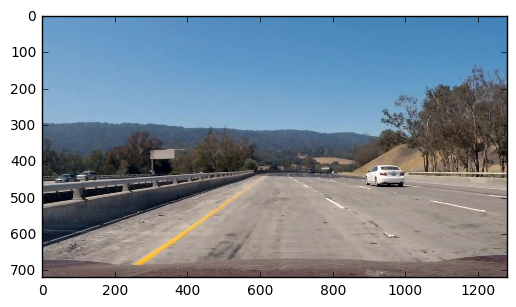

In [46]:
folder = "test_images\\"
paths = os.listdir(folder)
n = len(paths)
test_images = np.zeros((n, 720, 1280, 3))
for i, path in enumerate(paths):
    img = cv2.imread(os.path.join(folder, path))
    test_images[i] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
print("Test image loaded")
plt.figure()
plt.imshow(test_images[1].astype(np.uint8))
plt.show()

## Multiscale window computation

In [47]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [48]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop == [None, None]:
        x_start_stop = [0, img.shape[1]]
    if y_start_stop == [None, None]:
        y_start_stop = [0, img.shape[0]]
        
    # Compute the span of the region to be searched
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((x_span-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((y_span-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop
    for i in range(nx_windows):
        for j in range(ny_windows):
            # Calculate each window position
            startx = i*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = j*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            bbox = ((startx, starty),(endx, endy))
            # Append window position to list
            window_list.append(bbox)
    # Return the list of windows
    return window_list

In [49]:
def compute_windows(img):
    windows_far = slide_window(test_images[1], x_start_stop=[None, None], y_start_stop=[400, 480], xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    windows_mid = slide_window(test_images[1], x_start_stop=[None, None], y_start_stop=[400, 600], xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    windows_close = slide_window(test_images[1], x_start_stop=[None, None], y_start_stop=[500, 700], xy_window=(200, 200), xy_overlap=(0.5, 0.5))
    return [windows_far, windows_mid]

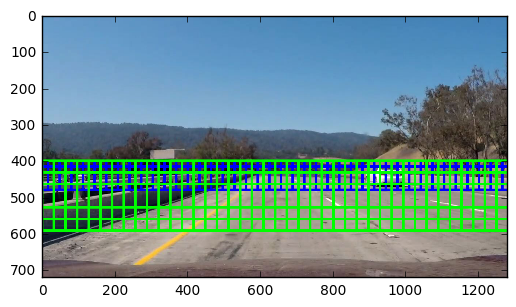

In [50]:
windows = compute_windows(test_images[1])
img = draw_boxes(test_images[1], windows[0], color=(0, 0, 255), thick=6)
img = draw_boxes(img, windows[1], color=(0, 255, 0), thick=6)
#img = draw_boxes(img, windows[2], color=(255, 0, 0), thick=6)
plt.imshow(img.astype(np.uint8))
plt.show()

## Camera calibration

In [51]:
def camera_calibration(path, nx = 9, ny = 6):
    """ Returns the camera matrix and the distortion coefficients based on the images stored 
    at the location provided in path.
    """
    # Initialisation of real and measured corner position
    obj_points = []
    img_points = []
    
    # Known real corner position
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    # Image list
    im_list = os.listdir(path)
    print(len(im_list), " images detected in folder")
    
    # Extract corners for each image
    for image in im_list:
        im_path = os.path.join(path, image)
        im = cv2.imread(im_path)
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == False:
            print("Corner detection failed for : ", image)
        else:
            obj_points.append(objp)
            img_points.append(corners)

    # Compute camera properties
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, 
                                                       gray.shape[::-1],None,None)
    return mtx, dist

In [52]:
path = 'C:\\Users\\ngnem2\\CarND-Advanced-Lane-Lines\\camera_cal'
print("Calibration folder : ", path)
mtx, dist = camera_calibration(path)
print("Camera matrix :")
print(mtx)
print("Distortion coefficients :")
print(dist)

Calibration folder :  C:\Users\ngnem2\CarND-Advanced-Lane-Lines\camera_cal
20  images detected in folder
Corner detection failed for :  calibration1.jpg
Corner detection failed for :  calibration4.jpg
Corner detection failed for :  calibration5.jpg
Camera matrix :
[[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Distortion coefficients :
[[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


In [53]:
def undistort(img, mtx, dist):
    """ Wrapper for the open cv undistort function that makes it easier to use.
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

## Apply classifier 

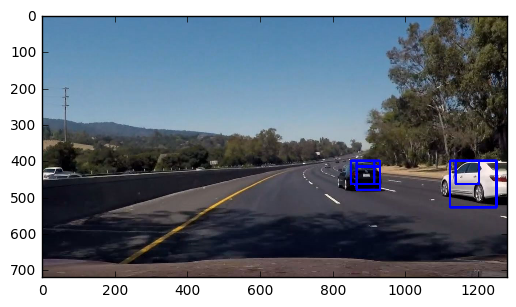

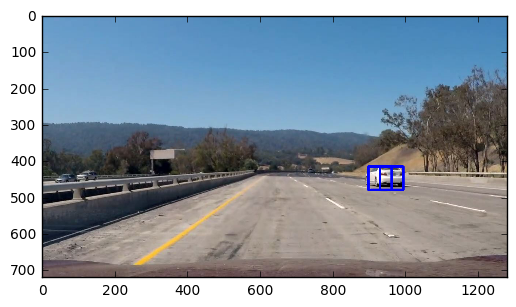

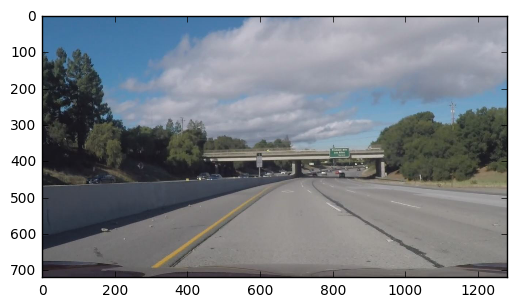

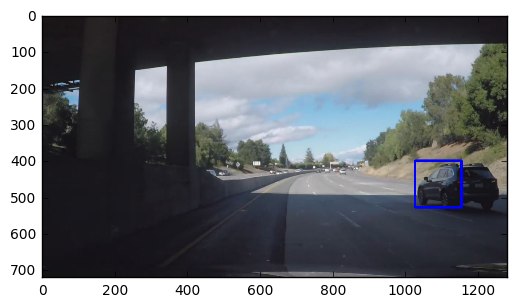

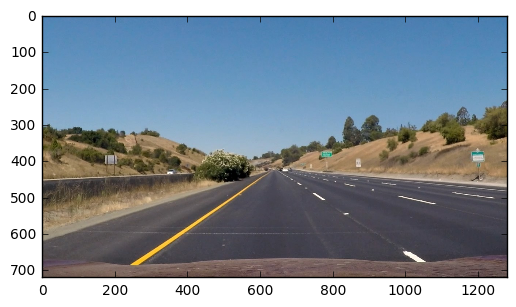

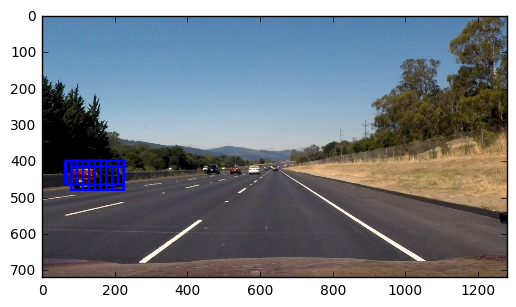

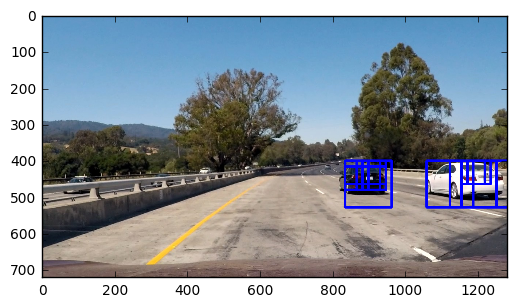

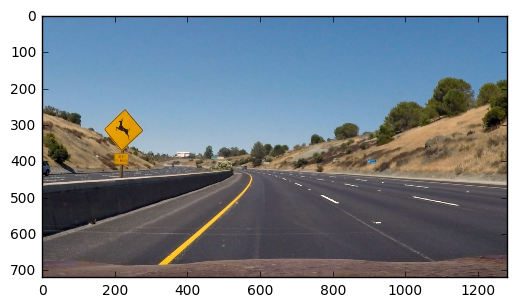

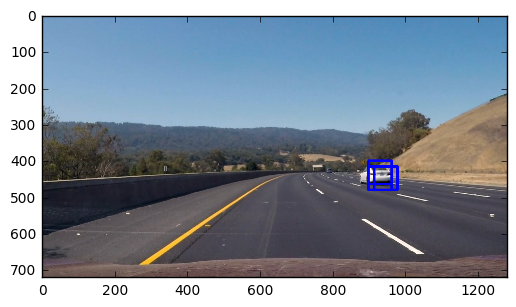

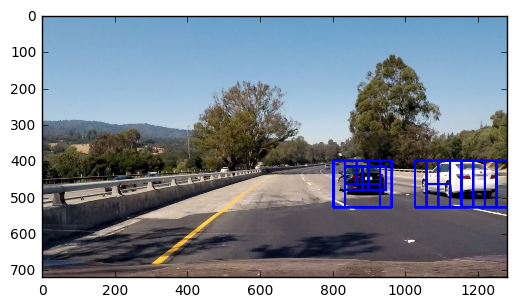

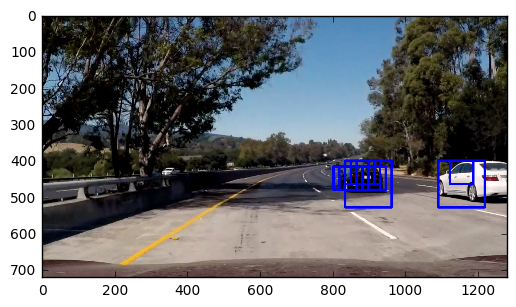

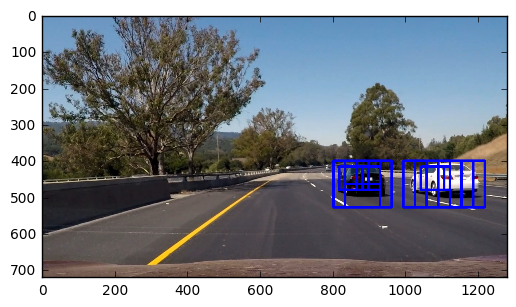

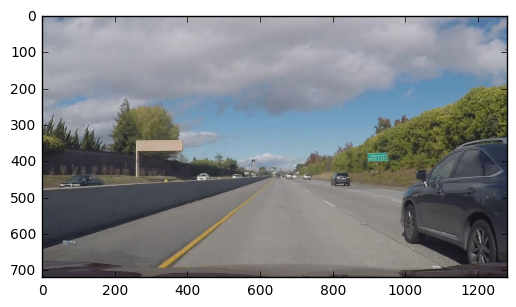

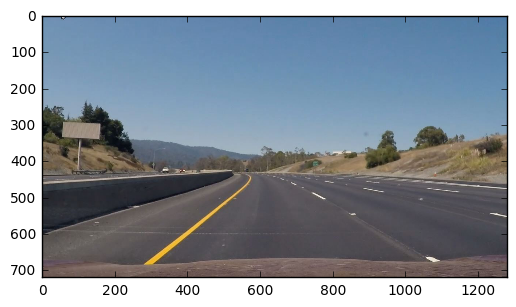

In [94]:
def find_cars(img_s, svc, scaler, settings):

    # Compute windows
    windows = compute_windows(img_s)
    
    # Saving
    bbox = []
    
    # Loop over windows
    for scale in windows:
        for window in scale:
            # Rescale to svc input
            x_0 = window[0][0]
            y_0 = window[0][1]
            x_1 = window[1][0]
            y_1 = window[1][1]
            subimg = cv2.resize(img_s[y_0:y_1, x_0:x_1], (64,64))
            #plt.imshow(subimg.astype(np.uint8))
            #plt.show()
            # Compute features
            features = extract_features(subimg.reshape([1, 64,64,3]), settings)
            features = scaler.transform(features)

            # Predict
            pred = svc.predict(features)

            # Add to list if detected
            if pred == 1:
                bbox.append(window)
    
    return bbox

n = test_images.shape[0]
for i in range(n):
    bbox = find_cars(test_images[i], svc, scaler, settings)
    img = draw_boxes(test_images[i], bbox, color=(0, 0, 255), thick=6)
    plt.imshow(img.astype(np.uint8))
    plt.show()

# Heat map and dectection

In [55]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [56]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [57]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [58]:
def heat_filter(image, bbox, thresh = 1):
    heat = np.zeros_like(image).astype(np.float)
    heat = add_heat(heat,bbox)
    heat = apply_threshold(heat,thresh)
    heatmap = np.clip(heat, 0, 255)
    return label(heatmap)

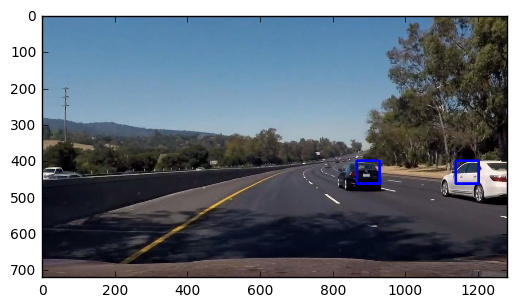

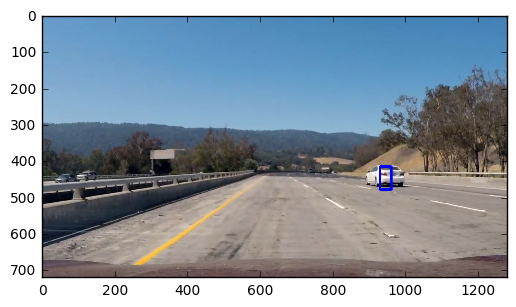

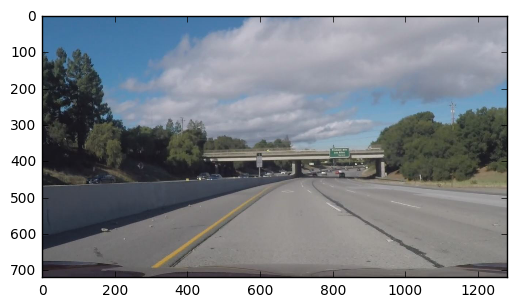

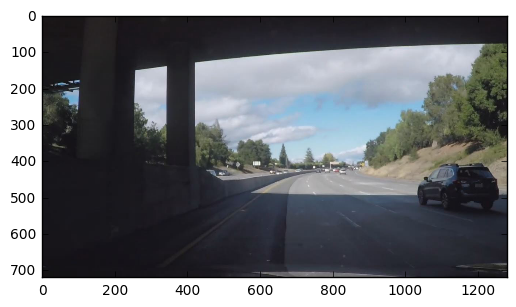

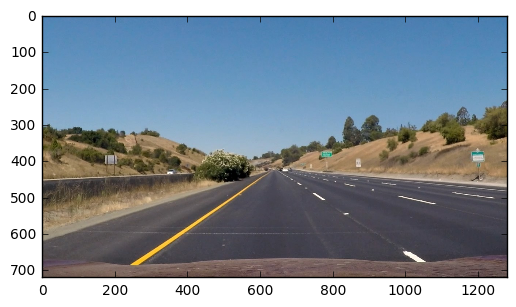

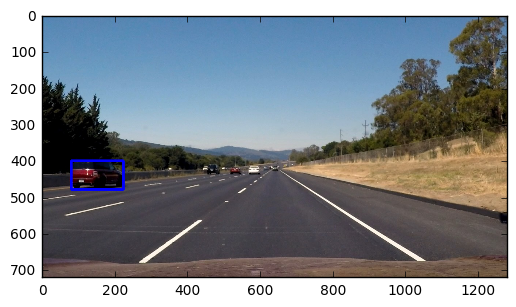

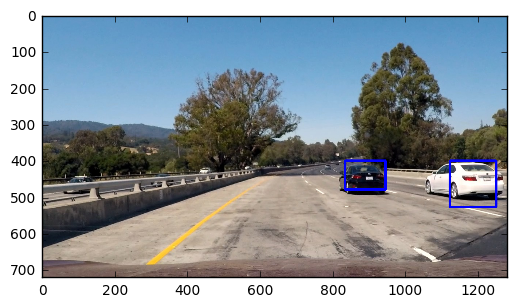

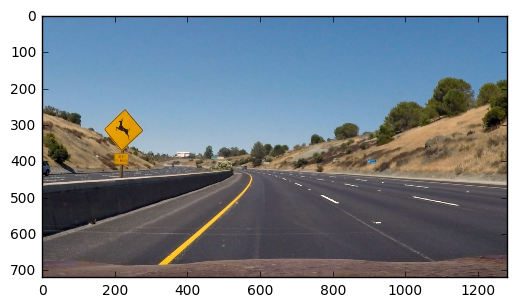

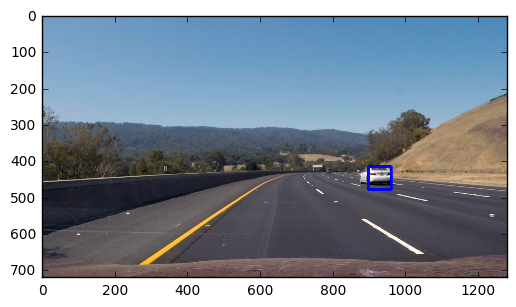

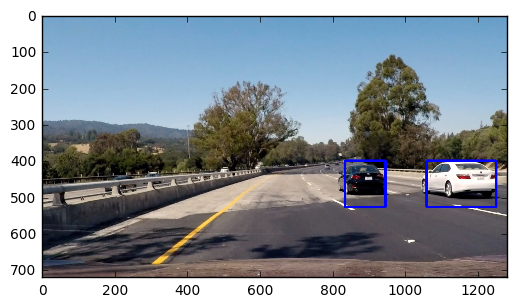

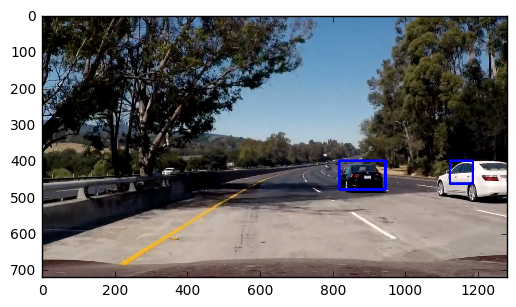

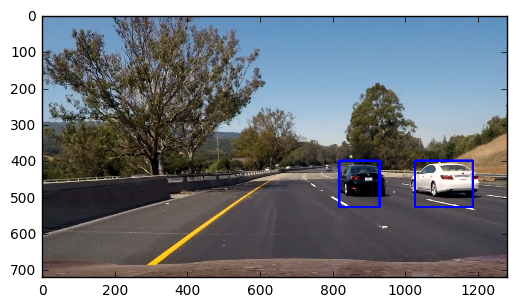

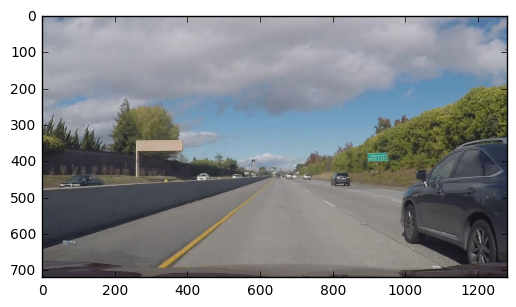

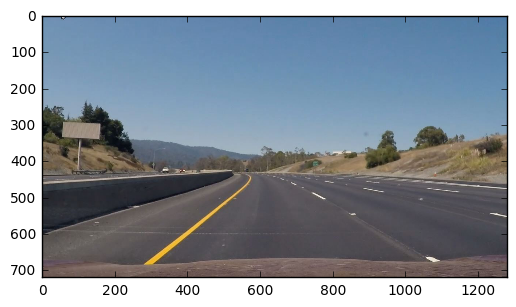

In [95]:
n = test_images.shape[0]
for i in range(n):
    bbox = find_cars(test_images[i], svc, scaler, settings)
    labels = heat_filter(test_images[i], bbox)
    draw_img = draw_labeled_bboxes(np.copy(test_images[i]), labels)
    plt.imshow(draw_img.astype(np.uint8))
    plt.show()

# Temporal tracking

## Kalman filtering

In [60]:
class StateSpace:
    def __init__(self, A, B, C, D, x0, Dt):
        
        # Save parameters
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        self.Dt = Dt
        self.x0 = x0
        
        # Compute vector sizes
        self.nx = self.A.shape[0]
        self.nu = self.B.shape[1]
        self.ny = self.C.shape[0]
        
        # Initialize internal state
        self.x = x0
        self.u = np.zeros((self.nu, 1))
        self.y = self.C.dot(x0)
        self.t = 0
        
    def evaluate(self, u = 0):
        self.u = u
        self.x = self.A.dot(self.x)+self.B.dot(self.u)
        self.y = self.C.dot(self.x)+self.D.dot(self.u) 
        self.t = self.t + self.Dt
        
    def __str__(self):
        out = "- Discrete state space model -\n"
        out += "nx = " + str(self.nx) + " | nu = " + str(self.nu) + " | ny = " + str(self.ny) + "\n"
        out += "A = \n" + str(self.A) + "\n"
        out += "B = \n" + str(self.B) + "\n"
        out += "C = \n" + str(self.C) + "\n"
        out += "D = \n" + str(self.D) + "\n"
        return out

In [61]:
class XYConstantAcceleration(StateSpace):
    def __init__(self, x0, dt):
        
        A0 = np.array([(1, dt, dt**2/2),
                       (0, 1,  dt),
                       (0, 0,  1)]) 
        A  = np.kron(np.eye(2), A0)
        B  = np.zeros((6,1))
        C  = np.array([(1, 0, 0, 0, 0, 0),
                       (0, 0, 0, 1, 0, 0)])
        D  = np.zeros((2,1))
        
        StateSpace.__init__(self,A,B,C,D,x0,dt)

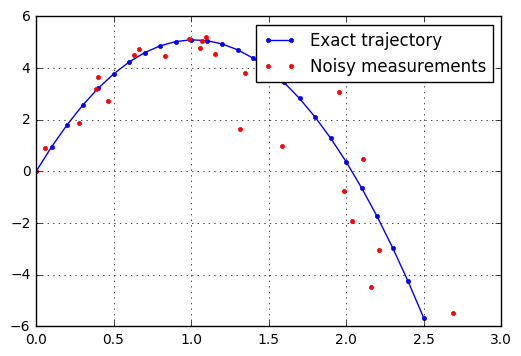

In [62]:
iterations = 26

# Saving vectors
t = np.zeros(iterations)
y = np.zeros((2,iterations))
y_n = np.zeros((2,iterations))

# Initial state
vx0 = 1
vy0 = 10
ax0 = 0
ay0 = -9.81
x0 = np.array([0,vx0,ax0,0,vy0,ay0]).reshape((6,1))

# System
ss = XYConstantAcceleration(x0,0.1)
sigma = 0.2

# Simulation
for i in range(iterations):
    t[i] = ss.t
    y[:,i] = ss.y.T
    y_n[:,i] = ss.y.T + np.random.normal()*sigma
    ss.evaluate()

# Plot
plt.plot(y[0,:],y[1,:],'.-')
plt.plot(y_n[0,:],y_n[1,:],'.r')
plt.legend(('Exact trajectory', 'Noisy measurements'))
plt.grid()
plt.show()

In [63]:
class LinearKalman():
    def __init__(self, model, x0, state_noise, measurement_noise):
        
        # Parameter extraction
        self.model = model
        self.state_noise = state_noise
        self.measurement_noise = measurement_noise
        
        # Internal state initialisation
        self.prior_state_est = x0
        self.post_state_est = x0
        self.prior_distrib = self.state_noise
        self.post_distrib = self.state_noise
        
    def predict_state(self):      
        self.prior_state_est = self.model.A.dot(self.post_state_est)
        self.prior_distrib = self.model.A.dot(self.post_distrib.dot(self.model.A.T)) + self.state_noise

    def predict_meas(self):
        y = self.model.C.dot(self.prior_state_est)
        S = self.model.C.dot(self.prior_distrib.dot(self.model.C.T)) + self.measurement_noise
        return y, S
    
    def update(self, y):
        self.predict_state()
        y_est, S = self.predict_meas()
        K = self.prior_distrib.dot(self.model.C.T.dot(np.linalg.inv(S)))
        v = y-y_est
        self.post_state_est = self.prior_state_est+K.dot(v)
        self.post_distrib = (np.eye(self.model.nx) - K.dot(self.model.C)).dot(self.prior_distrib)

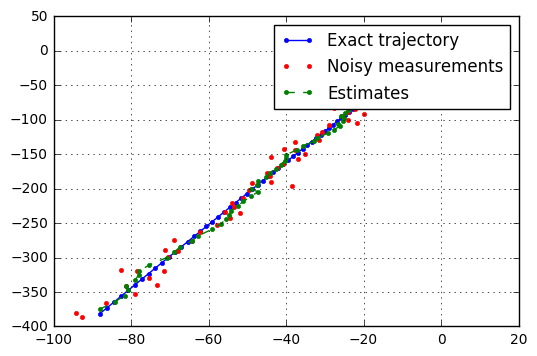

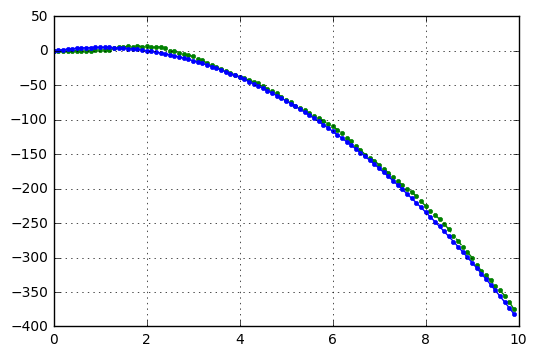

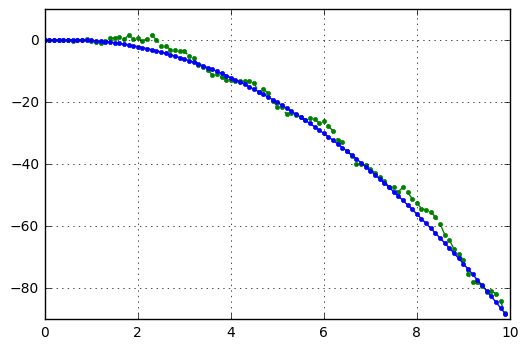

In [64]:
iterations = 100
t = np.zeros(iterations)
y = np.zeros((2,iterations))
y_n = np.zeros((2,iterations))
y_e = np.zeros((2,iterations))

vx0 = 1
vy0 = 10
ax0 = -2
ay0 = -9.81
x0 = np.array([0,vx0,ax0,0,vy0,ay0]).reshape((6,1))

ss = XYConstantAcceleration(x0,0.1)

sigma_meas = 4
R = np.eye(2)*sigma

sigma_a = 0.02
G = ss.A[0:3,2].reshape(3,1)
Q = G.dot(G.T)*sigma_a
Q = np.kron(np.eye(2), Q)
kf = LinearKalman(ss, np.zeros((6,1)), Q, R)

for i in range(iterations):
    t[i] = ss.t
    y[:,i] = ss.y.T
    y_e[:,i] = kf.model.C.dot(kf.post_state_est).T
    y_n[:,i] = ss.y.T + np.random.normal()*sigma_meas
    kf.update(y_n[:,i].reshape(2,1))
    ss.evaluate()

plt.plot(y[0,:],y[1,:],'.-')
plt.plot(y_n[0,:],y_n[1,:],'.r')
plt.plot(y_e[0,:],y_e[1,:],'--.g')
plt.legend(('Exact trajectory', 'Noisy measurements', 'Estimates'))
plt.grid()
plt.show()
plt.plot(t,y_e[1,:],'--.g')
plt.plot(t,y[1,:],'.-')
plt.grid()
plt.show()
plt.plot(t,y_e[0,:],'--.g')
plt.plot(t,y[0,:],'.-')
plt.grid()
plt.show()

## Detection projection to bird view

In [65]:
def bird_matrix(direction = 'normal'):
    # Parameters
    upper_y_offset = 115
    upper_x_offset = 555
    lower_x_offset = 250
    lower_y_offset = 20
    height = 720
    p_UL = (upper_x_offset, height/2 + upper_y_offset)
    p_LL = (lower_x_offset + 5, height - lower_y_offset)
    p_UR = (width - upper_x_offset, height/2 + upper_y_offset)
    p_LR = (width - lower_x_offset + 20, height - lower_y_offset)

    # Source shape
    src = np.array([p_UL,p_LL,p_UR,p_LR], dtype = np.float32)

    # Target shape
    offset_x = 300
    offset_y = 0
    height = 2000
    dst = np.array([[offset_x, offset_y],[offset_x, height-offset_y],[width - offset_x, offset_y],[width - offset_x, height-offset_y]], dtype = np.float32)

    # Apply transform
    if direction == 'normal':
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
    return M

In [66]:
def bird_transform(img):
    M = bird_matrix()
    width = 1280
    height = 2000
    return cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)

# Video

In [101]:
def pipeline(image):
    bbox = find_cars(image, svc, scaler, settings)
    bbox_stack.append(bbox)
    if len(bbox_stack) >= 5:
        del bbox_stack[0]
    labels = heat_filter(image, [item for sublist in bbox_stack for item in sublist], thresh = 3)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [102]:
output = 'out1.mp4'
clip = VideoFileClip("project_video.mp4")
global bbox_stack
bbox_stack = [];
clip = clip.fl_image(pipeline)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out1.mp4
[MoviePy] Writing video out1.mp4



100%|█████████████████████████████████████▉| 1260/1261 [24:52<00:01,  1.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out1.mp4 

Wall time: 24min 53s


In [103]:
output = 'out2.mp4'
clip = VideoFileClip("challenge_video.mp4")
global bbox_stack
bbox_stack = [];
clip = clip.fl_image(pipeline)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out2.mp4
[MoviePy] Writing video out2.mp4



100%|████████████████████████████████████████| 485/485 [09:22<00:00,  1.20s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out2.mp4 

Wall time: 9min 23s


# Conclusion